In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
df = pd.read_csv("./data/weather_with_avg_hourly_flight_delay.csv")
delay = df.copy()
delay.head()

,DATE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlySeaLevelPressure,HourlyStationPressure,HourlyPressureChange,HourlyPressureTendency,HourlyVisibility,HourlyWindSpeed,...,HourlyRelativeHumidity,REPORT_TYPE,cloud_1,cloud_0,wind_north,wind_east,wind_south,wind_west,join_time,avg_delay
0,2017-12-01T00:53:00,30.14,40.0,45.0,30.16,29.67,-0.00,3.0,10.0,13.0,...,83.0,FM-15,0,1,0,0,1,0,2017120100,-6.600000
1,2017-12-01T01:53:00,30.13,39.0,44.0,30.16,29.66,0.00,0.0,10.0,10.0,...,83.0,FM-15,0,1,0,0,1,0,2017120101,-10.000000
2,2017-12-01T05:53:00,30.08,36.0,42.0,30.10,29.61,0.00,0.0,10.0,10.0,...,79.0,FM-15,0,1,0,0,1,0,2017120105,-3.160000
3,2017-12-01T06:53:00,30.07,35.0,39.0,30.09,29.60,0.04,6.0,10.0,8.0,...,86.0,FM-15,0,1,0,0,1,0,2017120106,1.187500
4,2017-12-01T07:53:00,30.06,36.0,41.0,30.09,29.59,0.00,0.0,10.0,7.0,...,82.0,FM-15,1,0,0,0,1,0,2017120107,4.147541


In [2]:
delay.drop(['HourlySkyConditions', 'REPORT_TYPE', 'join_time'], axis=1, inplace=True)


In [3]:
delay.head()

,DATE,HourlyAltimeterSetting,HourlyDewPointTemperature,HourlyDryBulbTemperature,HourlySeaLevelPressure,HourlyStationPressure,HourlyPressureChange,HourlyPressureTendency,HourlyVisibility,HourlyWindSpeed,...,HourlyWetBulbTemperature,HourlyWindDirection,HourlyRelativeHumidity,cloud_1,cloud_0,wind_north,wind_east,wind_south,wind_west,avg_delay
0,2017-12-01T00:53:00,30.14,40.0,45.0,30.16,29.67,-0.00,3.0,10.0,13.0,...,43.0,200.0,83.0,0,1,0,0,1,0,-6.600000
1,2017-12-01T01:53:00,30.13,39.0,44.0,30.16,29.66,0.00,0.0,10.0,10.0,...,42.0,180.0,83.0,0,1,0,0,1,0,-10.000000
2,2017-12-01T05:53:00,30.08,36.0,42.0,30.10,29.61,0.00,0.0,10.0,10.0,...,39.0,210.0,79.0,0,1,0,0,1,0,-3.160000
3,2017-12-01T06:53:00,30.07,35.0,39.0,30.09,29.60,0.04,6.0,10.0,8.0,...,37.0,160.0,86.0,0,1,0,0,1,0,1.187500
4,2017-12-01T07:53:00,30.06,36.0,41.0,30.09,29.59,0.00,0.0,10.0,7.0,...,39.0,160.0,82.0,1,0,0,0,1,0,4.147541


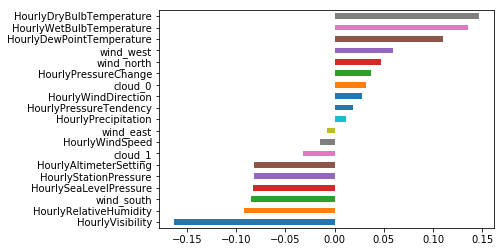

In [4]:
delay_corr = delay.corr()
(delay_corr
     .avg_delay
     .drop("avg_delay")
     .sort_values()
     .plot
     .barh())

In [5]:
import seaborn as sns

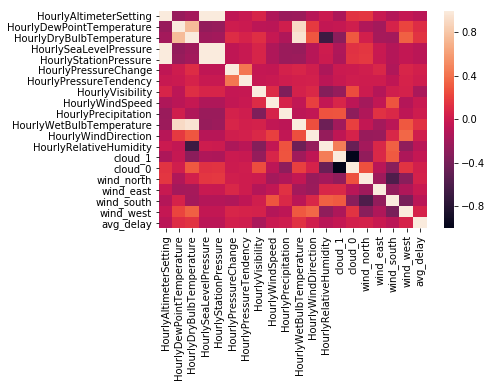

In [6]:
corr_heat = sns.heatmap(delay_corr)

In [7]:
delay.drop("DATE", axis=1, inplace=True)

In [8]:
def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model


model = forward_selected(delay, 'avg_delay')

print (model.model.formula)
# sl ~ rk + yr + 1

print (model.rsquared_adj)

avg_delay ~ HourlyVisibility + HourlyDryBulbTemperature + HourlyRelativeHumidity + HourlyAltimeterSetting + HourlySeaLevelPressure + HourlyPrecipitation + wind_south + HourlyDewPointTemperature + HourlyWetBulbTemperature + wind_north + HourlyStationPressure + HourlyWindSpeed + 1
0.06942188534126814


In [9]:
formula = 'avg_delay ~ HourlyVisibility + HourlyDryBulbTemperature + HourlyRelativeHumidity + HourlyAltimeterSetting + HourlySeaLevelPressure + HourlyPrecipitation + wind_south + HourlyDewPointTemperature + HourlyWetBulbTemperature + wind_north + HourlyStationPressure + HourlyWindSpeed + 1'
avg = smf.ols(formula= formula,data=delay).fit()
avg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              avg_delay   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     50.03
Date:                Tue, 12 Mar 2019   Prob (F-statistic):          3.29e-116
Time:                        22:18:14   Log-Likelihood:                -30715.
No. Observations:                7888   AIC:                         6.146e+04
Df Residuals:                    7875   BIC:                         6.155e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   176.0352     23.798      7.397      0.000     129.385     222.686
HourlyVisibility             -1.2697      0.075    -16.886      0.000      -1.417      -1.122
HourlyDryBulbTemperature      0.2498      0.118      2.115      0.034       0.018       0.481
HourlyRelativeHumidity       -0.2494      0.048     -5.232      0.000      -0.343      -0.156
HourlyAltimeterSetting     -222.4630     53.893     -4.128      0.000    -328.107    -116.819
HourlySeaLevelPressure      161.8531     28.981      5.585      0.000     105.043     218.663
HourlyPrecipitation         -25.6214      8.197     -3.126      0.002     -41.690      -9.553
wind_south                   -0.7703      0.366     -2.107      0.035      -1.487      -0.054
HourlyDewPointTemperature     1.0488      0.194      5.414      0.000       0.669       1.428
HourlyWetBulbTemperature     -1.1693      0.266     -4.393      0.000      -1.691      -0.648
wind_north                    0.6156      0.360      1.708      0.088      -0.091       1.322
HourlyStationPressure        56.6184     46.557      1.216      0.224     -34.645     147.882
HourlyWindSpeed               0.0367      0.033      1.117      0.264      -0.028       0.101
==============================================================================
Omnibus:                    10929.698   Durbin-Watson:                   1.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          7448795.177
Skew:                           7.675   Prob(JB):                         0.00
Kurtosis:                     152.760   Cond. No.                     6.37e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
p1 = avg.predict(delay)
delay["p1"] = p1

In [21]:
plt.figure(figsize = (250, 100))
delay.p1.plot(label="Predictions")
delay.avg_delay.plot(label="Actual")

plt.suptitle("Linear Predicted Delay vs. Actual average delay", fontsize = 200)
plt.legend()
plt.show()

C:\Users\liang\Anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\Users\liang\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


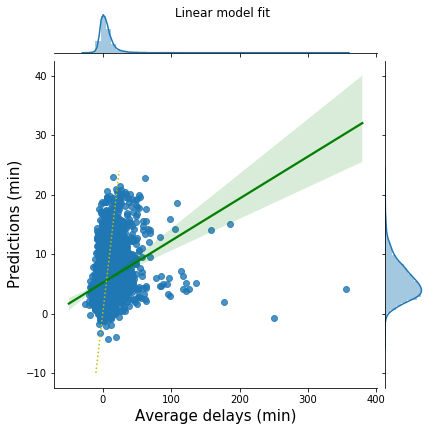

In [19]:
sns.jointplot(x="avg_delay", y="p1", data=delay, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'green'}}, kind='reg')
plt.xlabel('Average delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.suptitle("Linear model fit")
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'y')

In [13]:
from sklearn.metrics import mean_absolute_error

In [14]:
mean_absolute_error(delay.p1, delay.avg_delay)

6.948640984557691

In [15]:
from sklearn.metrics import mean_squared_error

In [16]:
mean_squared_error(delay.p1, delay.avg_delay)

141.1570533416928

In [17]:
delay.avg_delay[0]

-6.6

In [18]:
count = 0
for i in range(len(delay.avg_delay)):
    if abs(delay.avg_delay[i]-p1[i]) > 15: count += 1
'{:.2f}%'.format(count / len(p1) * 100)

'7.43%'